In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Clean up and group data by trips
vesel moving from N-H or H-N is considered as a complete trip

In [164]:
df = pd.read_csv("../../queenCsvOut.csv", skiprows=[1])
# plot_df = df[df.LATITUDE>48.9]

### There are some movements that does not belong to either N-H nor H-N trips

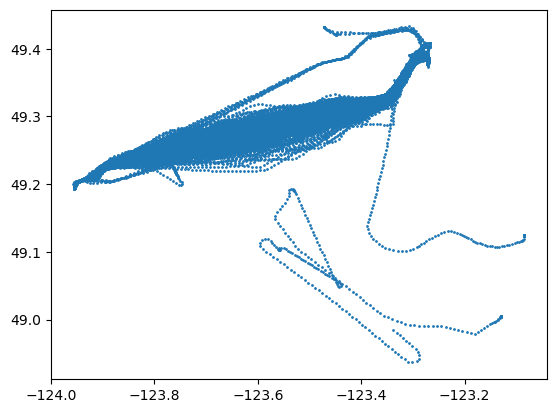

In [165]:
plot_df = df[df.LATITUDE>48.9]
plt.scatter(plot_df.LONGITUDE, plot_df.LATITUDE, s=1)

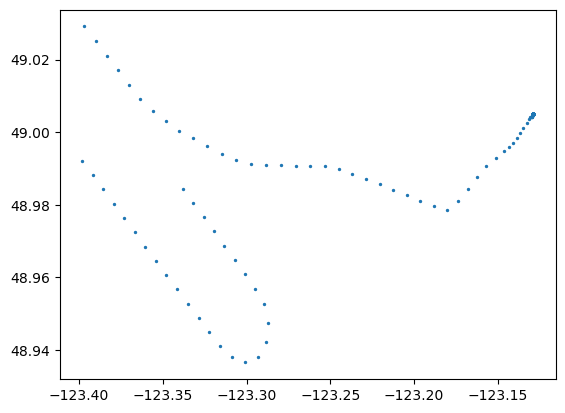

In [166]:
plot_df = df[df.LATITUDE>48.9]
tmp = plot_df[(plot_df["LATITUDE"]<49.1) & (plot_df["LONGITUDE"]> -123.4)]
plt.scatter(tmp.LONGITUDE, tmp.LATITUDE, s=2)

In [480]:
# Horseshoe Bay
# 49.3771, -123.2715
H_lat = 49.3771
H_long = -123.2715

# Nanaimo 
# 49.1936, -123.9554
N_lat = 49.1936
N_long = -123.9554

# Give each trip an ID (from H to N or N to H is counted as a complete trip)
# thresh: threshold for the area of the bay
def number_trip(bay_thresh = 1e-6, speed_thres=1):
    trip = np.zeros(df.shape[0])
    trip_id = 1
    trip[0] = trip_id
    prev_at_bay = True
    flag = True
    for i in range(1, len(df)):
        if (i % 50000)==0:
            print(i)
        H_dist = (df.iloc[i].LONGITUDE - H_long)**2 + (df.iloc[i].LATITUDE - H_lat)**2
        N_dist = (df.iloc[i].LONGITUDE - N_long)**2 + (df.iloc[i].LATITUDE - N_lat)**2
        # decide if the vessel in near the bay
        at_bay = (H_dist < bay_thresh) | (N_dist < bay_thresh)
        if (at_bay):
            # just enter the bay area
            # use flag to check if a new trip is counted
            if (prev_at_bay==False):
                flag = False
            # slows down, means the vessel is likely to be arrived
            # if hasn't generate a new trip id, do so
            if (flag==False) & (df.iloc[i].SOG <= speed_thres):
                trip_id += 1
                flag = True
            # if the vessel speed is very low near the bay area
            # parking at the bay, set trip id to 0
            if (df.iloc[i].SOG <= speed_thres):
                trip[i] = 0
            else:
                trip[i] = trip_id
        else:
            # if leave the bay, but new trip id hasn't been assigned
            # assgin new trip id
            if flag==False:
                trip_id += 1
                flag=True
            trip[i] = trip_id
        prev_at_bay = at_bay
    return trip

df.dropna(axis=0, thresh=35, inplace=True)
df["trip_id"] = number_trip().astype(int)


/Users/yim/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000


/Users/yim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [324]:
df.trip_id.min(), df.trip_id.max()

(0, 4117)

In [299]:
df.groupby(df.trip_id).count().head(20).Dati

trip_id
0     412951
1         13
2        105
3         12
4        109
5        107
6        106
7        109
8        106
9        105
10       107
11       105
12       112
13       113
14       105
15       107
16       107
17       104
18       109
19       105
Name: Dati, dtype: int64

In [296]:
df[df.trip_id==4113][["Time","LONGITUDE","LATITUDE"]]

,Time,LONGITUDE,LATITUDE
790026,1097719.0,-123.2715,49.3771
790027,1097720.0,-123.2715,49.3771
790369,1098062.0,-123.2714,49.3771
790370,1098063.0,-123.2715,49.3771
790398,1098091.0,-123.2715,49.3771
790399,1098092.0,-123.2714,49.3781
790400,1098192.0,-123.9335,49.2084
790401,1098193.0,-123.9392,49.2066
790402,1098194.0,-123.9452,49.2048
790403,1098195.0,-123.9508,49.2030


In [ ]:
# These are trips with extremely off locations, drop these trips
off_locations = list(df[df.LATITUDE<49.1].trip_id.unique())
df = df[~df.trip_id.isin(off_locations)]

In [ ]:
list(df[df.LATITUDE<49.1].trip_id.unique())

[2120.0]

Remove this abnormal trips along with some others with extremely off Longitude and Latitude

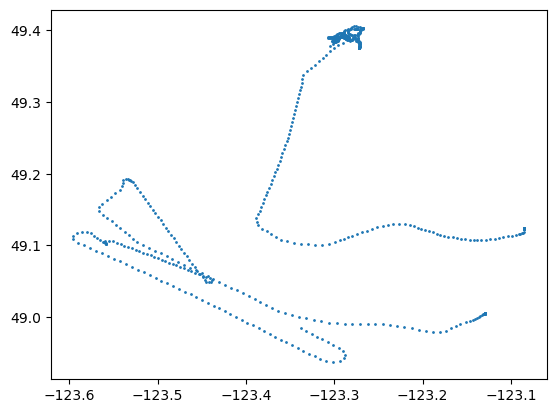

In [ ]:
plt.scatter(df[df.trip_id==2120].LONGITUDE, df[df.trip_id==2120].LATITUDE, s=1)

In [330]:
df.to_csv("../../clean_location.csv", index=False)

In [426]:
df = pd.read_csv("../../clean_location.csv")

### Clean up grouping
The grouping is not very accurate, for example, there are incomplete trips due to missingdata and abnormal trips that has the same starting and end point. This could be caused by two or more trips classfied into one (long_trips), or a short movement misclassfied into a single trip (short_trips). 


#### removing incomplete trips
Typically, a trip from N-H or H-N will take around 100-107 mins (with corresponding lines of data), the median is at 104.
Apperently any trip too long or too short is questionable. \
We will first remove trips with less then 30 lines of data. There are 835 of these trips

In [427]:
df.groupby(df.trip_id).count().Dati.quantile(0.25), df.groupby(df.trip_id).count().Dati.quantile(0.5), df.groupby(df.trip_id).count().Dati.quantile(0.75)

(100.0, 104.0, 107.0)

In [428]:
df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati<30]

trip_id
1       13
3       12
232      1
240     16
242     14
        ..
4109    10
4111    10
4113    15
4115    11
4117     3
Name: Dati, Length: 835, dtype: int64

In [429]:
incomplete_trips = list(df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati<30].index)
df = df[~df.trip_id.isin(incomplete_trips)]
df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati<30]

Now, look at the trips with too much lines of data 

In [431]:
df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati>150]

trip_id
0       414140
233       4771
352        499
436        182
908        440
931       4278
949       3258
1018      2977
1022       406
1066       812
1367       432
1607       395
2589       546
3766       164
3791       412
Name: Dati, dtype: int64

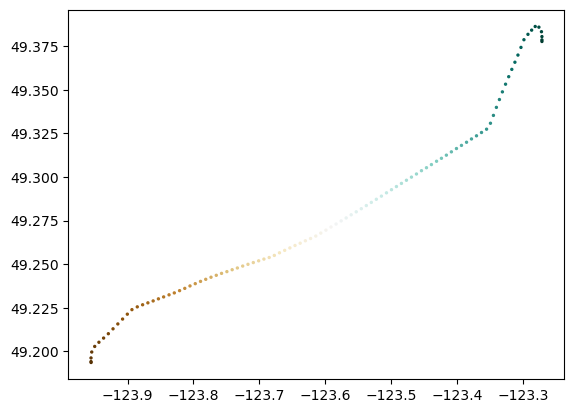

In [568]:
plt.scatter(df[df.trip_id==355].LONGITUDE, df[df.trip_id==355].LATITUDE, s=2, c=df[df.trip_id==355].Time, cmap="BrBG")

These abnormally long trips are caused by null values in location data/
If we observed more carefully, these data also contain a lot of 0's in other fields./
Drop them and see what happens

In [448]:
tmp = df[df.trip_id==352]
tmp[tmp.LONGITUDE.isna()]

,Dati,Time,CARGO,CARGO_PAX,DEPTH,ENGINE_1_FLOWRATE,ENGINE_1_FLOWRATEA,ENGINE_1_FLOWRATEB,ENGINE_1_FLOWTEMPA,ENGINE_1_FLOWTEMPB,...,THRUST_1,THRUST_2,TORQUE_1,TORQUE_2,TRACK_MADE_GOOD,WIND_ANGLE,WIND_SPEED,WIND_ANGLE_TRUE,WIND_SPEED_TRUE,trip_id
62634,191018_050900,70881.0,1.000000e+09,1.0,0.0,0.0000,0.0000,0.0000,24.5000,26.2000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
62635,191018_051000,70882.0,1.000000e+09,1.0,0.0,0.0000,0.0000,0.0000,24.5000,26.1967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
62636,191018_051100,70883.0,1.000000e+09,1.0,0.0,0.0000,0.0000,0.0000,24.5000,26.1250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
62637,191018_051200,70884.0,1.000000e+09,1.0,0.0,0.0000,0.0000,0.0000,24.5050,26.1000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
62638,191018_051300,70885.0,1.000000e+09,1.0,0.0,0.0000,0.0000,0.0000,24.5550,26.1000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63128,191018_132300,71375.0,1.000000e+09,1.0,0.0,-37.4103,2987.9280,2950.5178,19.6617,21.9667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
63129,191018_132400,71376.0,1.000000e+09,1.0,0.0,-38.0465,2987.4600,2949.4136,19.5567,22.2283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
63130,191018_132500,71377.0,1.000000e+09,1.0,0.0,-38.2765,2987.1396,2948.8630,19.5000,22.4450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352
63131,191018_132600,71378.0,1.000000e+09,1.0,0.0,-39.0241,2986.3032,2947.2791,19.5000,22.5867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,352


In [449]:
tmp = df[df.trip_id==436]
tmp[tmp.LONGITUDE.isna()]

,Dati,Time,CARGO,CARGO_PAX,DEPTH,ENGINE_1_FLOWRATE,ENGINE_1_FLOWRATEA,ENGINE_1_FLOWRATEB,ENGINE_1_FLOWTEMPA,ENGINE_1_FLOWTEMPB,...,THRUST_1,THRUST_2,TORQUE_1,TORQUE_2,TRACK_MADE_GOOD,WIND_ANGLE,WIND_SPEED,WIND_ANGLE_TRUE,WIND_SPEED_TRUE,trip_id
78463,191030_044900,88143.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,22.0000,25.5000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
78464,191030_045000,88144.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,22.0467,25.5000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
78465,191030_045100,88145.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,22.1000,25.5000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
78466,191030_045200,88146.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,22.1000,25.5033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
78467,191030_045300,88147.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,22.1000,25.5817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78640,191030_074600,88320.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,23.6200,25.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
78641,191030_074700,88321.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,23.6133,25.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
78642,191030_074800,88322.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,23.6117,25.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436
78643,191030_074900,88323.0,1.000000e+09,1.0,0.0,0.0,0.0,0.0,23.6050,25.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,436


When LONGITUDE is missing, and both thrusts == 0, these data does not contain any information about how the vessel is driving. It is safe to drop them.

In [457]:
# When LONGITUDE is missing, and both thrusts == 0, 
df[pd.isna(df.LONGITUDE) & (df.THRUST_1==0) &(df.THRUST_2==0)].sum()[df[pd.isna(df.LONGITUDE) & (df.THRUST_1==0) &(df.THRUST_2==0)].sum()==0]

LATITUDE              0.0
LONGITUDE             0.0
PAX                   0.0
POWER_1               0.0
POWER_2               0.0
RATE_OF_TURN          0.0
SOG                   0.0
SOG_SPEEDLOG_LONG     0.0
SOG_SPEEDLOG_TRANS    0.0
SPEED_2               0.0
THRUST_1              0.0
THRUST_2              0.0
TORQUE_1              0.0
TORQUE_2              0.0
TRACK_MADE_GOOD       0.0
WIND_ANGLE_TRUE       0.0
WIND_SPEED_TRUE       0.0
dtype: object

In [458]:
df = df[~(pd.isna(df.LONGITUDE) & (df.THRUST_1==0) &(df.THRUST_2==0))]

After these data are dropped, most of the abnormally long trips goes away

In [490]:
df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati>150]

trip_id
0       421080
3087       162
Name: Dati, dtype: int64

A special case where a detour happened

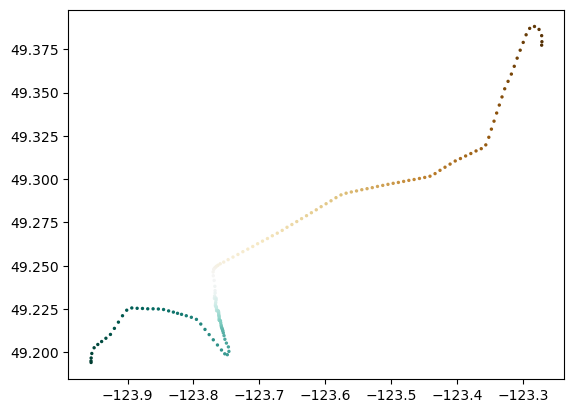

In [485]:
plt.scatter(df[df.trip_id==3087].LONGITUDE, df[df.trip_id==3087].LATITUDE, s=2, c=df[df.trip_id==3087].Time, cmap="BrBG")

In [354]:
def find_short_trip(df):
    short_trip = []
    long_trip = []
    trips = list(df.trip_id.unique())
    trips.remove(0)
    for i in trips:
        tmp_df = df[df.trip_id == i].reset_index()
        start_long, start_lat = tmp_df.iloc[0].LONGITUDE,tmp_df.iloc[0].LATITUDE
        end_long, end_lat = tmp_df.iloc[-1].LONGITUDE,tmp_df.iloc[-1].LATITUDE
        if (abs(start_long - end_long) < 0.005) and (abs(start_lat- end_lat) < 0.005):
            min_long, min_lat = tmp_df.LONGITUDE.min(), tmp_df.LATITUDE.min()
            max_long, max_lat = tmp_df.LONGITUDE.max(), tmp_df.LATITUDE.max()
            if ((max_long-min_long)>0.1) | ((max_lat-min_lat)>0.1):
                long_trip.append(i)
            else:
                short_trip.append(i)
    return short_trip, long_trip
short_trips, long_trips = find_short_trip(df)

abnormal trips that has the same starting and end point. This could be caused by two or more trips classfied into one (long_trips), or a short movement misclassfied into a single trip (short_trips). 
### Explore the cause of "long trips"
cause: jumps in location caused by missing data

In [356]:
long_trips

[220, 1292, 1307, 1387, 1474, 1587, 1668]

In [270]:
df[df.trip_id==220][["Time","LONGITUDE","LATITUDE","SOG"]].to_csv("tmp.csv")

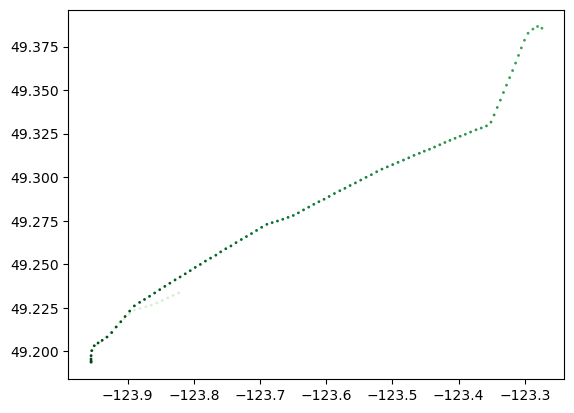

In [261]:
plt.scatter(df[df.trip_id==220].LONGITUDE, df[df.trip_id==220].LATITUDE, s=1, c=df[df.trip_id==220].Time, cmap="Greens")

In [363]:
# find the time corresponding to the incomplete part of the long trips
def find_drop_times(df, long_trips):
    to_drop = []
    for trip_id in long_trips:
        times = list(df[df.trip_id==trip_id].Time)
        count = 0
        i = 0
        # the jump in time is less than 5 mins
        while(((times[i+1]-times[i])< 5) & (i<len(times)-2)):
            count = count+1
            i = i+1
        # if the more complete trip happens earlier
        if count < len(times)/2:
            drop_time = times[0:count+1]
        else:
            drop_time = times[count+1:-1]
        to_drop = to_drop + drop_time
    return to_drop
time_to_drop = find_drop_times(df, long_trips)
df = df[~df.Time.isin(time_to_drop)]


There is no more long trips after we delete the incomplete part of the trip

## Explore "short trips"

In [491]:
short_trips, _ = find_short_trip(df)
short_trips

[1699]

In [492]:
df[df.trip_id==1699][["Time","LONGITUDE", "LATITUDE","SOG"]]

,Time,LONGITUDE,LATITUDE,SOG
426761,641277.0,-123.2712,49.3781,0.000
426762,641278.0,-123.2712,49.3781,0.000
426763,641279.0,-123.2712,49.3781,0.000
426764,641280.0,-123.2712,49.3782,0.000
426765,641281.0,-123.2712,49.3782,0.000
426766,641282.0,-123.2712,49.3783,0.000
426767,641283.0,-123.2712,49.3784,0.000
426768,641284.0,-123.2712,49.3784,0.000
426769,641285.0,-123.2711,49.3785,0.000
426770,641286.0,-123.2711,49.3785,0.000


In [501]:
df.loc["trip_id"] = df.trip_id.apply(lambda x: 0 if x==1699 else x)

/Users/yim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


### Cases where the time within a trip is not continuous:
some of these cases are already removed when trips with too few lines of data, we will see if there is more of these cases

In [525]:
def get_discontinuous_trip(df, time_thres=10):
    discontinous = {}
    trips = list(df.trip_id.unique())
    trips.remove(0)
    for i in trips:
        tmp_df = df[df.trip_id==i].reset_index()
        fill_in = tmp_df.Time.max()
        tmp_df["time_up"] = tmp_df["Time"].shift(periods=-1, fill_value=fill_in)
        tmp_df["time_diff"] = tmp_df["time_up"] - tmp_df["Time"]
        if tmp_df.time_diff.max() > time_thres:
            discontinous[i] = tmp_df.time_diff.max() 
    return discontinous

In [527]:
trip_dict = get_discontinuous_trip(df, time_thres=10)

In [529]:
trip_dict

{1.0: 146.0,
 218.0: 120.0,
 279.0: 158.0,
 306.0: 15.0,
 310.0: 43.0,
 328.0: 37.0,
 887.0: 240.0,
 998.0: 120.0,
 1013.0: 120.0,
 1092.0: 120.0,
 1179.0: 120.0,
 1230.0: 43.0,
 1291.0: 120.0,
 1369.0: 120.0,
 1387.0: 525.0,
 1663.0: 80.0,
 2191.0: 56.0,
 2197.0: 56.0,
 2203.0: 56.0,
 2211.0: 56.0,
 2219.0: 56.0,
 2227.0: 55.0,
 2235.0: 55.0,
 2243.0: 53.0,
 2251.0: 52.0,
 2259.0: 55.0,
 2267.0: 56.0,
 2275.0: 56.0,
 2283.0: 56.0,
 2291.0: 56.0,
 2297.0: 54.0,
 2303.0: 56.0,
 2309.0: 55.0,
 2315.0: 55.0,
 2331.0: 55.0,
 2339.0: 55.0,
 2345.0: 55.0,
 2351.0: 55.0,
 2357.0: 55.0,
 2363.0: 56.0,
 2369.0: 56.0,
 2375.0: 55.0,
 2381.0: 53.0,
 2387.0: 55.0,
 2393.0: 55.0,
 2399.0: 55.0,
 2405.0: 55.0,
 2411.0: 55.0,
 2417.0: 55.0,
 2423.0: 55.0,
 2429.0: 55.0,
 2435.0: 54.0,
 2441.0: 55.0,
 2447.0: 55.0,
 2454.0: 55.0,
 2460.0: 55.0,
 2466.0: 54.0,
 2472.0: 50.0,
 2478.0: 54.0,
 2484.0: 54.0,
 2490.0: 54.0,
 2502.0: 51.0,
 2508.0: 55.0,
 2514.0: 55.0,
 2520.0: 55.0,
 2526.0: 55.0,
 2532.0: 

In [543]:
trips_to_process = trip_dict.keys()

There are two cases in those discontinuous times: 
1. we can still find a continuous trip
2. there is a gap in the trip

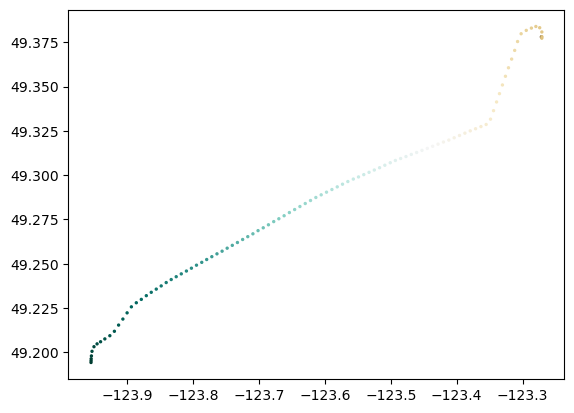

In [539]:
plt.scatter(df[df.trip_id==1230.0].LONGITUDE, df[df.trip_id==1230.0].LATITUDE, s=2, c=df[df.trip_id==1230.0].Time, cmap="BrBG")

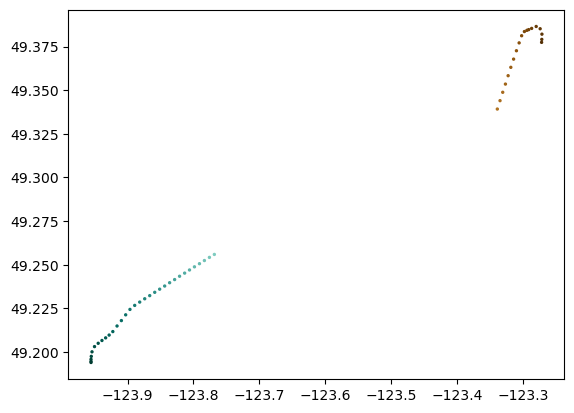

In [541]:
plt.scatter(df[df.trip_id==2235.0].LONGITUDE, df[df.trip_id==2235.0].LATITUDE, s=2, c=df[df.trip_id==2235.0].Time, cmap="BrBG")

What we can do is:
first trim down the shorter time period of the trip (just like how we clean up long trips previously)

In [546]:
time_to_drop = find_drop_times(df, trips_to_process)
df = df[~df.Time.isin(time_to_drop)]

Now, find the incomplete trips and delete them

In [579]:
trips_to_drop = (df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati<60]).index

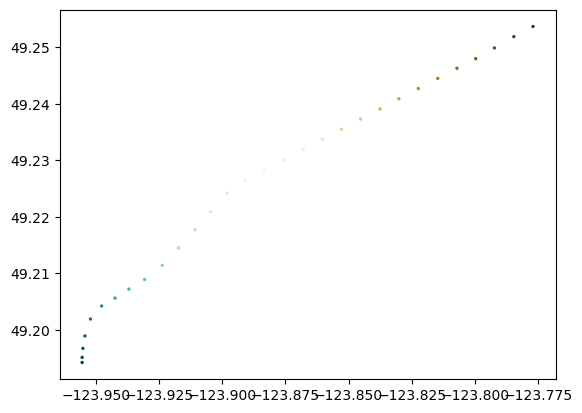

In [550]:
plt.scatter(df[df.trip_id==2191.00].LONGITUDE, df[df.trip_id==2191.00].LATITUDE, s=2, c=df[df.trip_id==2191.0].Time, cmap="BrBG")

In [581]:
df = df[~df.trip_id.isin(trips_to_drop)]

In [582]:
df.trip_id = df.trip_id.astype(int)
df.to_csv("../../df_cleaned_location.csv", index=False)

In [572]:
df.groupby("trip_id").count().Dati.quantile(.01), df.groupby("trip_id").count().Dati.median(), df.groupby("trip_id").count().Dati.quantile(.99)

(97.0, 103.0, 113.0)